In [1]:
import chess
import chess.engine
import os
import sys
import chess.pgn
import subprocess

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

import utils.chess_utils as chess_utils
from utils.pikeBot_chess_utils import *

from evaluation_utils import *

In [2]:
def get_maia_path(maia_elo):
    if maia_elo == 1100:
        return "D:/Program Files/MaiaChess/Maia1/lc0.exe"
    if maia_elo == 1500:
        return "D:/Program Files/MaiaChess/Maia5/lc0.exe"
    if maia_elo == 1900:
        return "D:/Program Files/MaiaChess/Maia9/lc0.exe"
    raise ValueError("Maia elo must be from (1100, 1500, 1900)")


In [3]:
class MaiaChess(chess_utils.Player):
    def __init__(self, maia_path: str) -> None:
        super().__init__()
        #redirect error stderr not to display messages from the engine
        self.engine = chess.engine.SimpleEngine.popen_uci(maia_path, stderr=subprocess.DEVNULL)

    def get_best_move(self, board):
        result = self.engine.play(board, chess.engine.Limit(nodes=1))
        move = result.move
        return move

### Parameters setup
set path parameters to your local resources and evaluation parameters depending on your evaluation setup

In [4]:
#path parameters
stockfish_path = "D:/Program Files/Stockfish/stockfish/stockfish-windows-x86-64-avx2.exe"
model_path = "../Models/PikeBot_Models/PikeBot.pth"
preprocessing_parameters_path = "../model_loading_data/preprocessing_parameters.json"

#evaluation parameters
time_limit = 0.01
evaluation_dataset_paths = ['games/silversuite.pgn']

### Engine definition
By default engine1 is a maia chess engine simulating human behavior but you can modify it if you want other engine comparison. Both engines must be of a child class of chess_utils.Player.

In [5]:
maia_elo = 1100
maia_path = get_maia_path(maia_elo)
engine1 = MaiaChess(maia_path)

In [6]:
model = PikeBotModelWrapper(model_path, preprocessing_parameters_path)
engine2 = Pikebot( model=model, 
                        aggregate=chess_utils.mean_aggr,
                        stockfish_path=stockfish_path,
                        color=chess.WHITE,
                        opponents_elo = maia_elo
                        )
            

### Dataset loading

In [7]:
boards_datasets = dict()
for path in evaluation_dataset_paths:
    pgn = open(path)
    boards_dataset = list()

    while True:
        board = chess.Board()
        game = chess.pgn.read_game(pgn)
        if game is None:
            break
        for move in game.mainline_moves():
            board.push(move)
        boards_dataset.append(board)

    boards_datasets[path] = boards_dataset


### Evaluation code

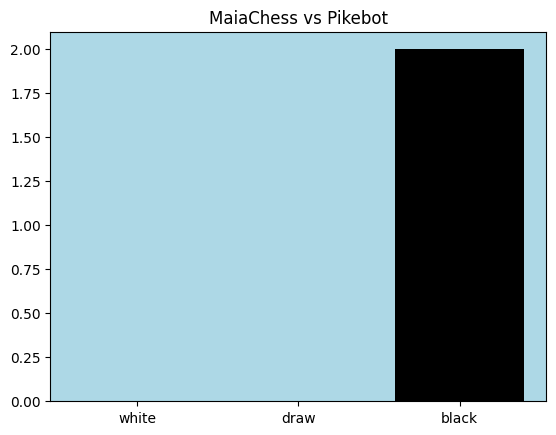

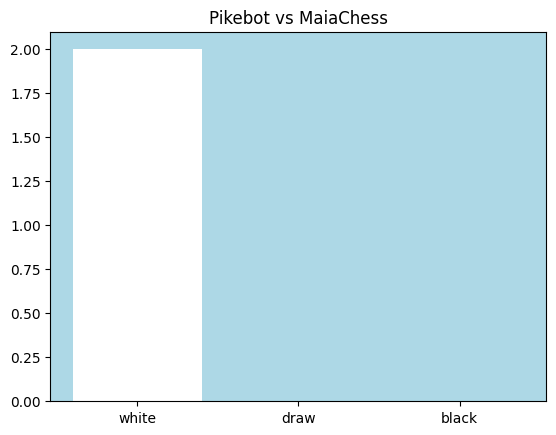

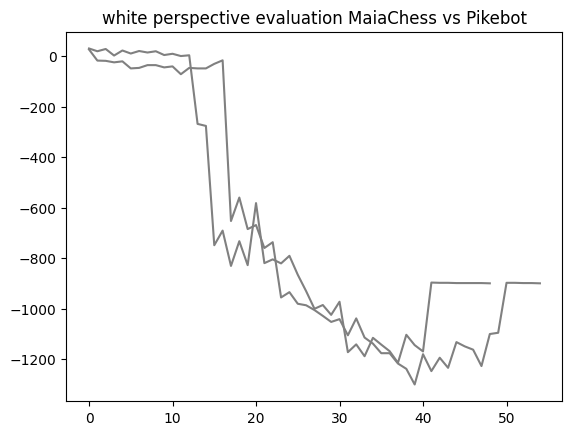

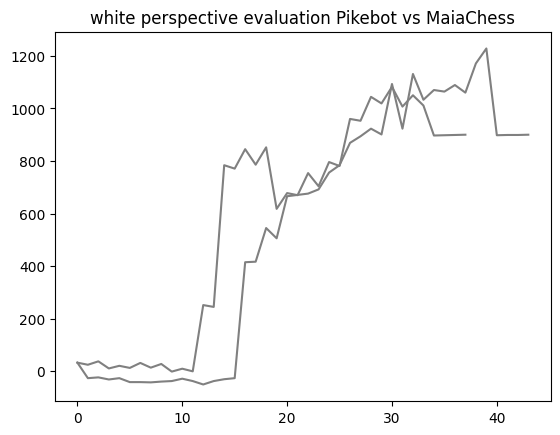

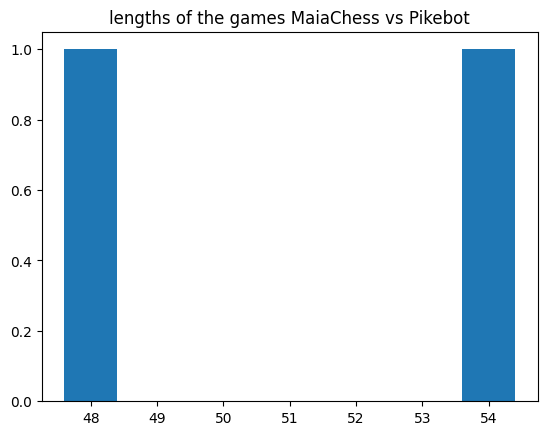

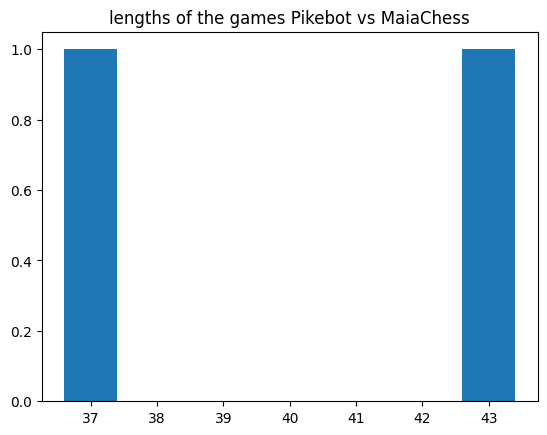

In [8]:
for path, boards_dataset in boards_datasets.items():
    result1, boards1 = compare_engines(engine1, engine2, boards_dataset)
    result2, boards2 = compare_engines(engine2, engine1, boards_dataset)

    name1, name2 = type(engine1).__name__, type(engine2).__name__
    
    #define saving directory
    path_to_save = path.replace('games/', '')
    path_to_save = path_to_save.replace('.pgn', '')
    timestamp = time.asctime().replace(' ', '_')
    timestamp = timestamp.replace(':', '-')

    dir_path = f'{name1}_{name2}_{path_to_save}_{timestamp}'
    os.makedirs(f'results/{dir_path}', exist_ok=True) 
    os.makedirs(f'results/{dir_path}/games', exist_ok=True) 
    os.makedirs(f'results/{dir_path}/statistics', exist_ok=True) 
    os.makedirs(f'results/{dir_path}/plots', exist_ok=True) 

    #get move evaluation and save games
    evaluation1 = process_games(boards1, name1, name2, dir_path)
    evaluation2 = process_games(boards2, name2, name1, dir_path)

    #plot results and save plots
    process_results(result1, name1, name2, dir_path)
    process_results(result2, name2, name1, dir_path)

    process_evaluation(evaluation1, name1, name2, dir_path)
    process_evaluation(evaluation2, name2, name1, dir_path)

    process_length(boards1, name1, name2, dir_path) 
    process_length(boards2, name2, name1, dir_path) 